In [2]:
import skimage as sk
from skimage import io
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

In [3]:
def read_img(im_name):
    im = io.imread(im_name)
    return im

def read_and_convert(im_name):
    im = io.imread(im_name)
    im = sk.img_as_float(im)
    return im

def normalize(im):
    return (im - im.min())/(im.max()-im.min())

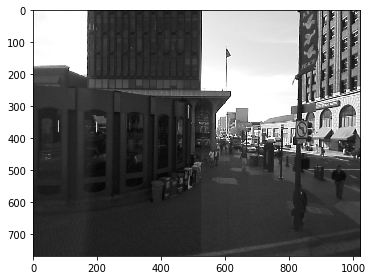

In [4]:
"""problem 1"""
berkeley = read_img('./pset2/Berkeley.jpg')
io.imshow(berkeley)

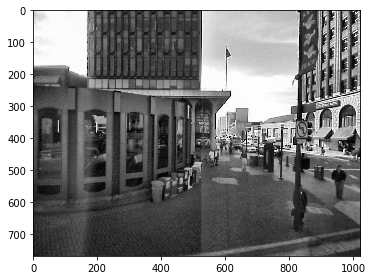

In [5]:
"""WRITEUP:
   In this project, I used adaptive histogram equalization. 
   Procedure below:
   1) The image is divided into small blocks. 
   2) For each block, if a contrast limit exists there, 
      clip the pixels
   3) Apply histogram equalization. 
   4) At the tile borders, do bilinear interpolation. """

n_bins = 256
def clip_hist(im, threshold):
    hist, bins = np.histogram(im.flatten(), n_bins, [0, n_bins])
    threshold = im.flatten().shape[0] / n_bins * threshold
    mu = (hist[hist>=threshold] - threshold).sum() / n_bins
    clipped = ((threshold+mu)*(hist>=threshold)+(hist+mu)*(hist<threshold)).astype('uint8')
    return clipped
    
def cdf(hist, block_m, block_n):
    const_a = (n_bins - 1) / (block_m * block_n)
    hists_cdf = (const_a * np.cumsum(hist)).astype("uint8")
    return hists_cdf
    
        
def adaptive_hist_equalization(img_arr, tileGridSize, threshold):
    arr = np.zeros(img_arr.shape)
    H, W = img_arr.shape
    h, w = int(H / tileGridSize[0]), int(W / tileGridSize[1])
    cdfs = [[cdf(clip_hist(img_arr[i*h:(i+1)*h, j*w:(j+1)*w], threshold), h, w) for j in range(tileGridSize[1])] for i in range(tileGridSize[0])]

    for i in range(H):
        r = int((i-h/2)/h)
        x = (i-(r+0.5)*h)/h 
        for j in range(W):
            c = int((j-w/2)/w)
            y = (j-(c+0.5)*w)/w 
            ref = img_arr[i][j]
            if r < 0 and (c < 0 or c >= tileGridSize[1] - 1):
                col = c+1 if c < 0 else c
                arr[i][j] = cdfs[r + 1][col][ref]
            elif r >= tileGridSize[0] - 1 and (c < 0 or c >= tileGridSize[1] - 1):
                col = c+1 if c < 0 else c
                arr[i][j] = cdfs[r][col][ref]
            elif r < 0 or r >= tileGridSize[0] - 1:
                r = np.clip([r], 0, tileGridSize[0] - 1)[0]
                arr[i][j] = (1-y) * cdfs[r][c][ref] + y * cdfs[r][c+1][ref]
            elif c < 0 or c >= tileGridSize[1] - 1:
                c = np.clip([c], 0, tileGridSize[1] - 1)[0]
                arr[i][j] = (1-x) * cdfs[r][c][ref] + x * cdfs[r+1][c][ref]
            else:
                lu = cdfs[r][c][ref]
                lb = cdfs[r + 1][c][ref]
                ru = cdfs[r][c + 1][ref]
                rb = cdfs[r + 1][c + 1][ref]
                arr[i][j] = (1-y) * ((1-x) * lu + x * lb) + y * ((1-x) * ru + x * rb)
    return arr.astype("uint8")

"""RESULT"""
enhanced = adaptive_hist_equalization(berkeley, tileGridSize=(8,8), threshold=3)
io.imshow(enhanced)

In [6]:
"""3.3"""
"""(a)"""
def histEqual4e(f):
    hist, _ = np.histogram(f.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    ref = 255 * cdf / (f.size)
    im = np.zeros(f.shape)
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            im[i,j] = ref[f[i,j]]
    return im.astype('uint8')

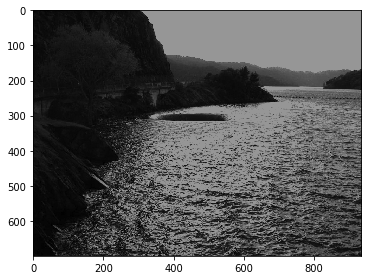

In [7]:
spillway = read_img('./PSet2_Images/PSet2 Images/spillway-dark.tif')
io.imshow(spillway)

In [8]:
def plot_hist(img):
    hist, _ = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    plt.hist(img.flatten(),256, [0,256], color = 'r')
    plt.xlim([0,256])
    plt.show()

"My prject3.2(c) is a totally different from this image...\n   So I'm not very sure how to compare. But in terms of the \n   effect, they are similar"

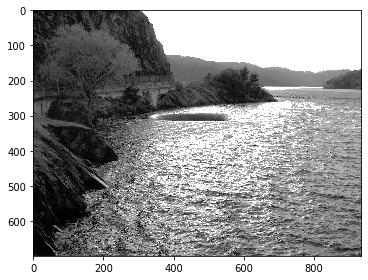

In [9]:
"""b"""
equalized = histEqual4e(spillway)
io.imshow(equalized)
"""My prject3.2(c) is a totally different from this image...
   So I'm not very sure how to compare. But in terms of the 
   effect, they are similar"""

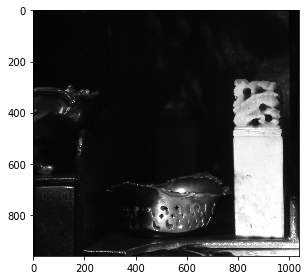

In [10]:
"""(c)"""
horse = read_img('./PSet2_Images/PSet2 Images/hidden-horse.tif')
io.imshow(horse)

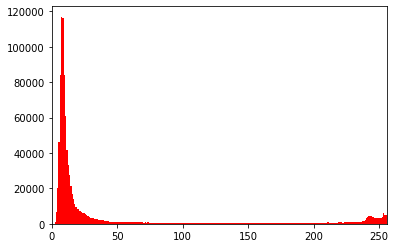

In [11]:
plot_hist(horse)

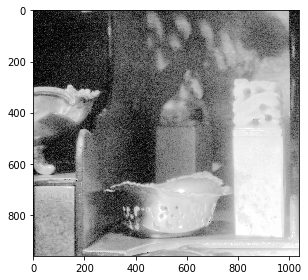

In [12]:
equalized_horse = histEqual4e(horse)
io.imshow(equalized_horse)

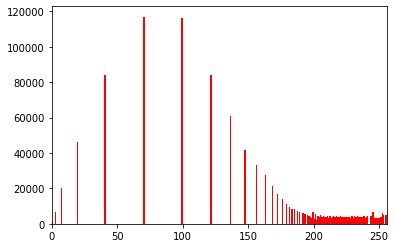

In [13]:
plot_hist(equalized_horse)

In [14]:
"""Compare: they(3.25 and my results) look very similar, 
   except that mine is a bit noiser"""

'Compare: they(3.25 and my results) look very similar, \n   except that mine is a bit noiser'

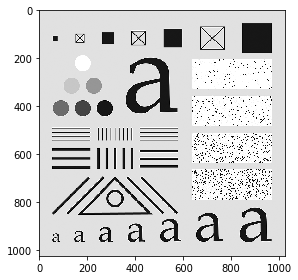

In [15]:
"""3.7"""
"""(a)"""
pattern = read_and_convert('./PSet2_Images/PSet2 Images/testpattern1024.tif')
io.imshow(pattern)

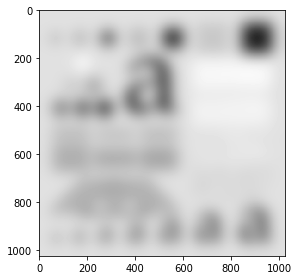

In [16]:
# def kernel_generator(sigma):
#     kernel_size = 3*sigma
#     if (kernel_size%2 == 0):
#         kernel_size += 1
#     result = np.empty([kernel_size, kernel_size])
#     for i in range(kernel_size):
#         x = abs(2*i - kernel_size)//2
#         for j in range(kernel_size):
#             y = abs(2*j - kernel_size)//2
#             result[i, j] = np.exp(-(x * x + y * y) / (sigma * sigma)) / (2 * np.pi * (sigma * sigma))
#     result = result/result.sum()
#     return result

# def low_pass(image, sigma):
#     kernel = kernel_generator(sigma)
#     result = signal.convolve2d(image, kernel, mode="same", boundary="symm")
#     return np.clip(result, -1, 1)
# blurred = low_pass(pattern, 20)
blurred = cv2.GaussianBlur(pattern, ksize=(187,187), sigmaX=31, sigmaY=31)
io.imshow(blurred)

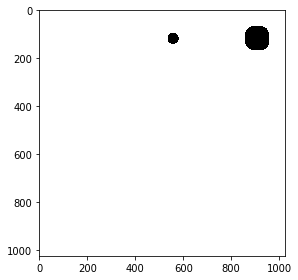

In [33]:
"""(b)"""
blurred = cv2.GaussianBlur(pattern.copy(), ksize=(151,151), sigmaX=25, sigmaY=25) > .37
io.imshow(blurred)

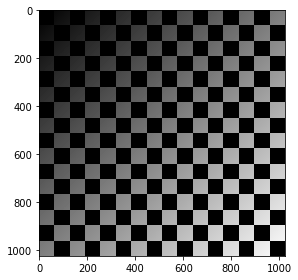

In [34]:
"""(c)"""
checkerboard = read_and_convert('./PSet2_Images/PSet2 Images/checkerboard1024-shaded.tif')
io.imshow(checkerboard)

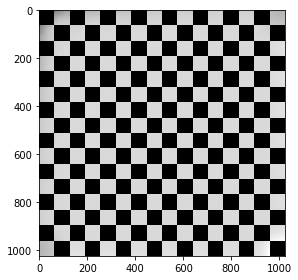

In [35]:
kernel = cv2.GaussianBlur(checkerboard, ksize=(64*4-1,64*4-1), sigmaX=64, sigmaY=64)
corrected = normalize(checkerboard/kernel)
io.imshow(corrected)

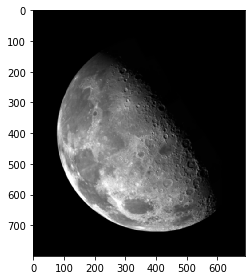

In [36]:
"""3.8"""
"""(a)"""
moon = read_and_convert('./PSet2_Images/PSet2 Images/blurry-moon.tif')
io.imshow(moon)

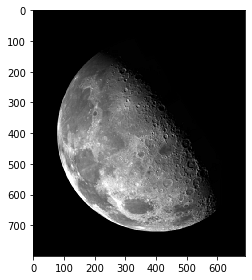

In [37]:
blurry_moon = cv2.GaussianBlur(moon, ksize=(5, 5), sigmaX=3, sigmaY=3)
sharpened = moon + (moon - blurry_moon)
sharpened = np.clip(sharpened, 0, 1)
io.imshow(sharpened)

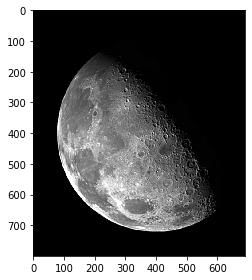

In [38]:
"""(b)"""
high_boosted = moon + 3*(moon - blurry_moon)
high_boosted = np.clip(high_boosted, 0, 1)
io.imshow(high_boosted)

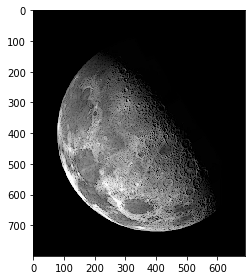

In [39]:
"""3.9"""
"""(a)"""
"""Similarity: They are both sharpened, with more details visuable. 
   Difference: Compared. to 3.8(a), it shows more details and the 
           surface looks less smooth. 3.8(a) also looks 
           a bit brighter. """
lap_filter = cv2.Laplacian(moon, cv2.CV_64F, ksize=1)
lap_filter = np.clip(lap_filter, 0, 1)
lap_filter = normalize(lap_filter)
sharpened = moon - lap_filter
sharpened = np.clip(sharpened, 0, 1)
io.imshow(sharpened)


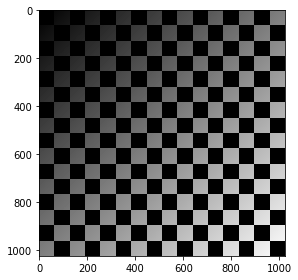

In [40]:
"""(b)"""
checkerboard = read_and_convert('./PSet2_Images/PSet2 Images/checkerboard1024-shaded.tif')
io.imshow(checkerboard)

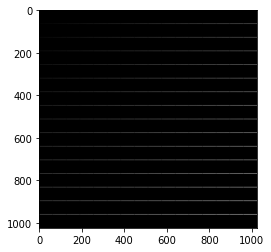

In [43]:
d = np.abs(cv2.filter2D(checkerboard, -1, np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])))
plt.imshow(d, cmap='gray')

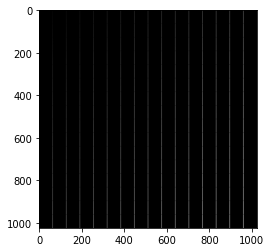

In [55]:
e = np.abs(cv2.filter2D(checkerboard, -1, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])))
plt.imshow(e, cmap='gray')

In [47]:
"""Filter d is a horizontal edge detector 
   and Filter e is a vertical edge detector. 
   They represent an approximation of the image gradient, 
   by using a weighted comvination of intensity values of 
   its surronding pixels, which has the optimal values
   at the edges. 
   """

'Filter d is a horizontal edge detector \n   and Filter e is a vertical edge detector. \n   They represent an approximation of the image gradient, \n   by using a weighted comvination of intensity values of \n   its surronding pixels, which has the optimal values\n   at the edges. \n   '

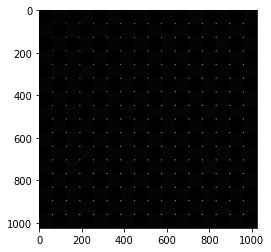

In [56]:
"""(c)"""
"""We apply edge detector to get all the horizontal edges
   then aplly a vertical edge filter. Therefore, only their
   intersections remain. """
both = np.abs(cv2.filter2D(d, -1, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])))
both = np.clip(both, 0, 1)
plt.imshow(both, cmap='gray')

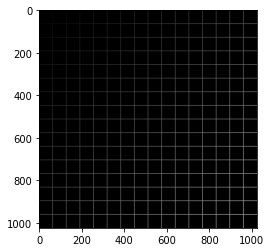

In [59]:
"""(d)"""
"""The gradient on the edge is the largest because there
   is a huge difference between white and black blocks(pixels). 
   For the other parts of the image, the gradient is 
   basically 0 because nothing change there. """
d = np.abs(cv2.filter2D(checkerboard, -1, np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])))
e = np.abs(cv2.filter2D(checkerboard, -1, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])))
grad = np.sqrt(d**2+e**2)
plt.imshow(grad, cmap='gray')